In [5]:
import logging
import os
from pathlib import Path
import re
import json
from typing import Any
from pydantic import BaseModel
from scipy.stats import gaussian_kde
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import dask
dask.config.set({'dataframe.query-planning': True})
import dask.dataframe as dd
from visualization.plot_experiments_result import read_data_to_df

from visualization.plot_experiments_result import makespan_histogram_pd

In [6]:
experiments_path = Path("~/sched_exps/base_sched/base_sched").expanduser()

In [7]:
cases = [1, 2, 3, 4, 5, 6, 8]
methods = ['overlapschedule', 'randomallocation', 'maxduration', 'dynamicallocation']

In [8]:
df = read_data_to_df(experiments_path.glob("*.json"), cols={"initial_makespan": -1, "final_makespan": -1,  "FAIL": False})

Unterminated string starting at: line 1 column 32768 (char 32767)
/home/username/sched_exps/base_sched/base_sched/sched_case_6_method_overlapschedule_dist_seed_8_schedule_seed_35_sim_seed_0_det_job_False_answer_seed_0.json


OSError: Could not read /home/username/sched_exps/base_sched/base_sched/sched_case_6_method_overlapschedule_dist_seed_8_schedule_seed_35_sim_seed_0_det_job_False_answer_seed_0.json.

In [33]:
dask_df = dd.from_pandas(df, chunksize=10000)

In [14]:
folder_path = os.path.join(experiments_path, 'base_sched/')
extracted_files = os.listdir(folder_path)
extracted_files = [Path(folder_path+file) for file in extracted_files if '.json' in file and '.ipynb' not in file]
df = read_data_to_df(extracted_files, {"makespan": -1, "FAIL": False})

Expecting ',' delimiter: line 1 column 7166 (char 7165)
/home/behrejan/repos/rss24_sched/scheduling/src/exp_scripts/experiments/base_sched/sched_case_3_method_maxduration_dist_seed_3_schedule_seed_20_sim_seed_0_det_job_False_answer_seed_0.json


In [91]:
row = df.iloc[1]

def makespan_lb(row: pd.Series) -> float:
    return min(df["initial_makespan"][df["det_job"]==True][df["method_name"]=="overlapschedule"][df["dist_seed"] == row["dist_seed"]][df["case_number"] == row["case_number"]])

# makespan_lb(row=row)
ms_lb = dask_df.apply(makespan_lb, axis=1)

# df["initial_makespan"][df["method_name"] == "overlapschedule"][df["case_number"]]

/home/behrejan/miniconda3/envs/msched/lib/python3.10/site-packages/dask/dataframe/core.py:6280: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  )


In [92]:
ms_lb.compute()

0        119.0
1        141.0
2        145.0
3        131.0
4        133.0
         ...  
35995    129.0
35996    145.0
35997    169.0
35998    113.0
35999    135.0
Length: 36000, dtype: float64

In [59]:
df_one_exp = df[df["det_job"] == True][df["case_number"] == 5][df["dist_seed"]==5][df["method_name"]=="overlapschedule"]
ms_lb = min(df_one_exp["initial_makespan"][df_one_exp["sim_seed"]==df_one_exp["schedule_seed"]])

ms_norm = np.array(df_one_exp["final_makespan"] / ms_lb)
df['ms_norm'] = ms_norm

/tmp/ipykernel_3013650/1260777595.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["det_job"] == True][df["case_number"] == 5][df["dist_seed"]==5][df["method_name"]=="overlapschedule"]
/tmp/ipykernel_3013650/1260777595.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["det_job"] == True][df["case_number"] == 5][df["dist_seed"]==5][df["method_name"]=="overlapschedule"]
/tmp/ipykernel_3013650/1260777595.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["det_job"] == True][df["case_number"] == 5][df["dist_seed"]==5][df["method_name"]=="overlapschedule"]


ValueError: Length of values (100) does not match length of index (64000)

/tmp/ipykernel_3013650/1205404878.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/1205404878.py:33: ChainedAssignmentError: A value is trying to be set on a copy of a DataFrame or Series through chained assignment.
When using the Copy-on-Write mode, such chained assignment never works to update the original DataFrame or Series, because the intermediate object on which we are setting values always behaves as a copy.

Try using '.loc[row_indexer, col_indexer] = value' instead, to perform the assignment in a single step.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ms_norm"][df_one_exp.index] = df_one_exp["final_makespan"] / ms_lb
/tmp/ipykernel_3013650/1205404878.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = 

ValueError: autodetected range of [nan, nan] is not finite

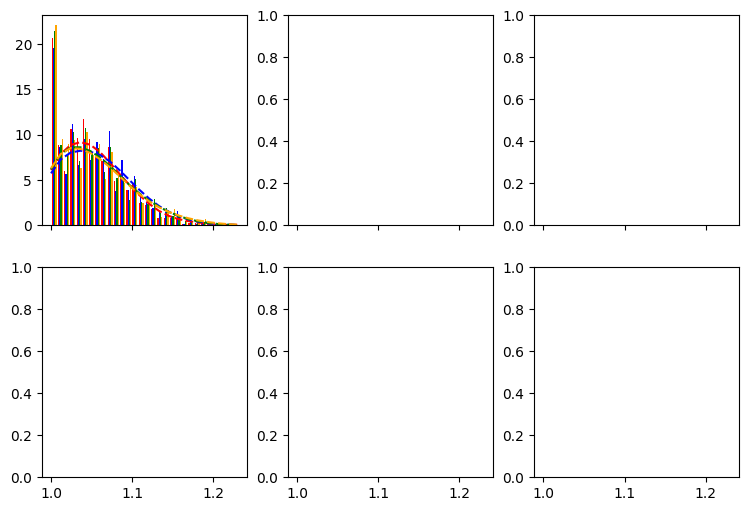

In [92]:
def set_density(ax, data, first=False):
    n_bins = 30

    color = ['red', 'blue', 'green', 'orange', 'black']

    ax.hist(data, n_bins, density=True, histtype='bar', color=color[:len(data)])
    xs = np.linspace(min(min(makespan) for makespan in data), max(max(makespan) for makespan in data), 20)

    for i, case in enumerate(data):
        density_re = gaussian_kde(case.tolist())
        density_re.covariance_factor = lambda: .50
        density_re._compute_covariance()
        ax.plot(xs, density_re(xs), "--", color=color[i])

    return ax, max(density_re(xs))

def makespan_histogram_single(df=df, save_path=experiments_path):
    fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6), sharex=True, sharey=False)
    axes = [ax0, ax1, ax2, ax3, ax4, ax5]


    legend: list[str] = []
    for case, ax in zip(cases, axes):
        makespans_other: list[list[int]] = []
        legend = []
        dist_seed = 5

        
        for dist_seed in np.unique(np.array(df["dist_seed"])):
            df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
            ms_lb = min(df_one_exp["initial_makespan"][df["det_job"] == True][df["method_name"]=="overlapschedule"][df_one_exp["sim_seed"]==df_one_exp["schedule_seed"]])

            df["ms_norm"][df_one_exp.index] = df_one_exp["final_makespan"] / ms_lb

        for method in methods:
            legend.append(method)
            # df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
            #     df["schedule_seed"] != 0][df['method_name'] == method]



            # original_makespan: list[int] = np.array(list((df3.get("makespan"))))[:, 0]
            # list_of_lists = [ast.literal_eval(l) for l in list(df3.get("makespan"))]
            makespans_other.append(np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:]))

            # makespans_other[-1].mean()
            # makespans_other[-1].std()
            # makespans_other[-1].max()
            # makespans_other[-1].min()


        _, ymax = set_density(ax, makespans_other)
            # ax.vlines(makespan_time_knowledge, ymin=0, ymax=ymax, color='red')


    # Set common labels
    fig.supxlabel('Makespan [s]')
    fig.supylabel('Density')
    ax1.legend(legend, ncol=3, loc='upper center',bbox_to_anchor=(0.5, 1.2))
    # fig.tight_layout()
    if save_path is not None:
        if save_path.is_file():
            fig.savefig(fname=save_path.__str__())
        elif save_path.is_dir():
            fig.savefig(save_path.joinpath("histogram_pd.png").__str__())
        else:
            raise ValueError(f"save_path has invalid type: {type(save_path)}. var: {save_path}")
    else:
        plt.show()

makespan_histogram_single(df=df)

/home/username/msched/scheduling/src/visualization/plot_experiments_result.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/home/username/msched/scheduling/src/visualization/plot_experiments_result.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/home/username/msched/scheduling/src/visualization/plot_experiments_result.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/home/username/msched/scheduling/src/visualization/plot_experiments_result.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/home/username/msched/scheduling/src/visuali

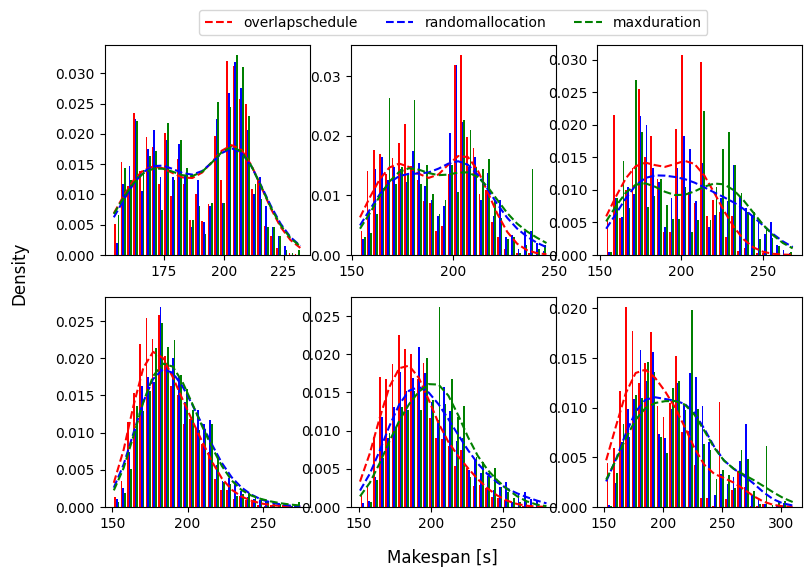

In [58]:
makespan_histogram_pd(df=df, save_path=experiments_path)

In [44]:
df["initial_makespan"] = np.array(list(df["makespan"]))[:,0]
df["final_makespan"] = np.array(list(df["makespan"]))[:,1]

case: 8, method: overlapschedule, data len: 2000
case: 8, method: randomallocation, data len: 2000
case: 8, method: maxduration, data len: 2000
case: 8, method: dynamicallocation, data len: 2000


/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
/tmp/ipykernel_3013650/37973145.py:15: UserWarning: Boolean 

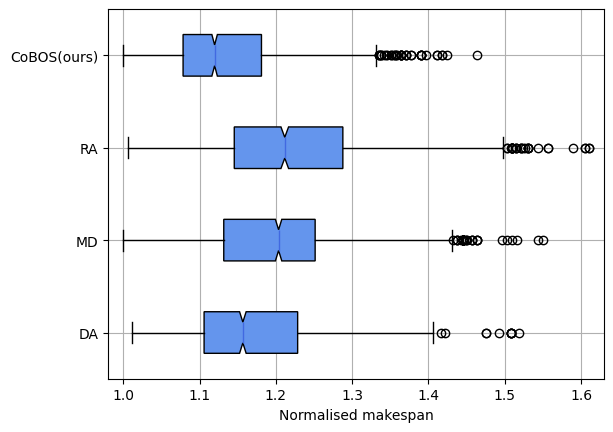

In [159]:
# BARPLOT
df['ms_norm'] = pd.Series(dtype=float)
fig, ax = plt.subplots()
# axes = [ax0, ax1, ax2, ax3, ax4, ax5]

selected_methods = ['overlapschedule', 'dynamicallocation']
data1 = np.empty((0,))
data2 = np.empty((0,))

legend: list[str] = []
for case in [8]:
# for method in methods:
    makespans_other: list[list[int]] = []
    for dist_seed in np.unique(np.array(df["dist_seed"])):
        df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
        ms_lb = min(df_one_exp["initial_makespan"][df["det_job"] == True][df["method_name"]=="overlapschedule"][df_one_exp["sim_seed"]==df_one_exp["schedule_seed"]])

        df.loc[df_one_exp.index, "ms_norm"] = df_one_exp["final_makespan"] / ms_lb
    data = []
    for method in methods:
    # for case in cases:
        data.append(np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:]))

        # mean = round(np.mean(data), 4)
        # percentile10 = round(np.percentile(data, 10), 4)
        # percentile90 = round(np.percentile(data, 90), 4)
        # std = round(np.std(data),4)
        print(f'case: {case}, method: {method}, data len: {len(data[-1])}')


bp = ax.boxplot(data, positions=[4, 3, 2, 1], patch_artist=True, notch=True, vert=False,
                labels=['CoBOS(ours)', 'RA', 'MD', 'DA'])
colors = ['cornflowerblue', 'cornflowerblue', 'cornflowerblue', 'cornflowerblue']
# colors = ['mediumblue', 'lightsteelblue', 'cornflowerblue', 'royalblue']
for box, color in zip(bp['boxes'], colors):
    box.set_facecolor(color)
for median in bp['medians']:
    median.set(color='royalblue',
               linewidth=1)
# ax.legend([bp["boxes"][0], bp["boxes"][1], bp["boxes"][2],bp["boxes"][3]], ["OS", 'RA', 'MD', "DA"], loc='lower right')
# ax.set_title(titels[f])
ax.set_xlabel('Normalised makespan')
ax.set_xlim(0.98,1.63)
plt.grid()
plt.savefig('boxplot_case_8_grid.svg')

In [22]:
df2 = df [df["FAIL"] == False][df["case_number"] == 4][df['dist_seed'] == 0][df["sim_seed"] == 0][df['method_name'] == 'overlapschedule'][df['det_job'] == True]
df2

/tmp/ipykernel_12141/3206922475.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df [df["FAIL"] == False][df["case_number"] == 4][df['dist_seed'] == 0][df["sim_seed"] == 0][df['method_name'] == 'overlapschedule'][df['det_job'] == True]
/tmp/ipykernel_12141/3206922475.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df [df["FAIL"] == False][df["case_number"] == 4][df['dist_seed'] == 0][df["sim_seed"] == 0][df['method_name'] == 'overlapschedule'][df['det_job'] == True]
/tmp/ipykernel_12141/3206922475.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df [df["FAIL"] == False][df["case_number"] == 4][df['dist_seed'] == 0][df["sim_seed"] == 0][df['method_name'] == 'overlapschedule'][df['det_job'] == True]
/tmp/ipykernel_12141/3206922475.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df [df["FAIL"] == False][df["case_number"] == 4

,case_number,schedule_seed,dist_seed,sim_seed,answer_seed,method_name,det_job,makespan,FAIL
649,4,81,0,0,0,overlapschedule,True,"[143, 209]",False
991,4,37,0,0,0,overlapschedule,True,"[151, 213]",False
1034,4,75,0,0,0,overlapschedule,True,"[157, 186]",False
1417,4,73,0,0,0,overlapschedule,True,"[135, 240]",False
2703,4,71,0,0,0,overlapschedule,True,"[135, 206]",False
...,...,...,...,...,...,...,...,...,...
35130,4,51,0,0,0,overlapschedule,True,"[138, 185]",False
35131,4,82,0,0,0,overlapschedule,True,"[156, 204]",False
35323,4,30,0,0,0,overlapschedule,True,"[133, 223]",False
35600,4,91,0,0,0,overlapschedule,True,"[143, 211]",False


/tmp/ipykernel_3013650/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_3013650/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_3013650/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_3013650/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_3013650/3384095562.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
/tmp/ipykernel_

TypeError: 'NoneType' object is not iterable

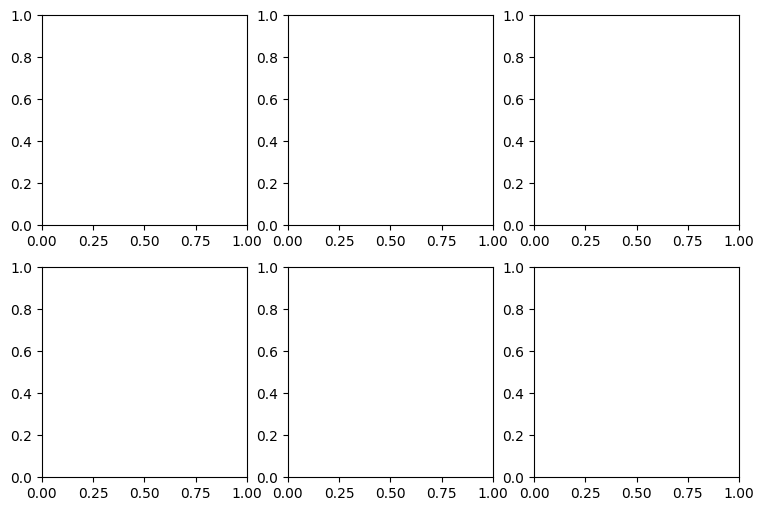

In [64]:
fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for case, ax in zip(cases, axes):
    for method in methods:
        if method == 'overlapschedule':
            df1 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] == 0][df['method_name'] == method][df['dist_seed'] == 0][df['det_job'] == True]

            df2 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] != 0][df['method_name'] == method][df['det_job'] == True]

            df3 = df[df["FAIL"] == False][df["case_number"] == case][df["sim_seed"] == 0][
                df["schedule_seed"] != 0][df['method_name'] == method][df['det_job'] == False]

            # makespan_time_knowledge = df1.at[df1.index[-1], "makespan"][1]

            det_job_makespan: list[int] = np.array(list((df2.get("makespan"))))[:, 1]
            stoch_job_makespans_other: list[int] = np.array(list((df3.get("makespan"))))[:, 1]
            _, ymax = set_density(ax, [det_job_makespan, stoch_job_makespans_other])
            # ax.vlines(makespan_time_knowledge, ymin=0, ymax=ymax, color='red')
        else:
            pass
            # df2 = df[df["FAIL"] == False][df["case_number"] == case][df["dist_seed"] == 0][df['method_name'] == method]


# Set common labels
fig.supxlabel('Makespan [s]')
fig.supylabel('Density')
ax1.legend(['Det job', 'Stoch job', 'Same seed'], ncol=3, loc='upper center',bbox_to_anchor=(0.5, 1.2))
# fig.tight_layout()
plt.show()

In [ ]:
## Statistics
df['ms_norm'] = pd.Series(dtype=float)
round_value = 2
for case in cases:
    makespans_other: list[list[int]] = []

    for dist_seed in np.unique(np.array(df["dist_seed"])):
        df_one_exp = df[df["case_number"] == case][df["dist_seed"]==dist_seed]
        ms_lb = min(df_one_exp["initial_makespan"][df["det_job"] == True][df["method_name"]=="overlapschedule"][df_one_exp["sim_seed"]==df_one_exp["schedule_seed"]])

        df.loc[df_one_exp.index, "ms_norm"] = df_one_exp["final_makespan"] / ms_lb
    for method in methods:
        data = np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:])
        mean = round(np.mean(data), round_value)
        print(f'{mean}')
    for method in methods:
        data = np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:])
        percentile10 = round(np.percentile(data, 10), round_value)
        print(f'{percentile10}')
    for method in methods:
        data = np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:])
        percentile90 = round(np.percentile(data, 90), round_value)
        print(f'{percentile90}')

    for method in methods:
        data = np.array(list(df["ms_norm"][df["case_number"]==case][df["method_name"]==method])[:])
        std = round(np.std(data), round_value)
        print(f'{std}')
        # print(f'{mean} {percentile10} {percentile90} {std}')
    print(f'case {case}___________')


In [ ]:
def read_data_to_df(files: list[Path], cols: dict[str, Any], ignore_missing:bool =False) -> pd.DataFrame:

    raw_data: list[dict[str, int|float|str]] = []

    for file_name in files:
        data = get_data_from_file(file_name)
        if not data:
            logging.warning(f"Could not read {file_name}.")
            continue

        exp_info = get_experiment_info(file_name.stem)

        raw_data.append(exp_info.dict())

        stats = data["statistics"]

        for col, default in cols.items():
            if col in stats:
                raw_data[-1][col] = stats[col]
            elif ignore_missing:
                pass
            else:
                raw_data[-1][col] = default
                # raise ValueError(f"{file_name} has no data about {col}.")


    df = pd.DataFrame(raw_data)

    return df

def get_data_from_file(file_name: Path):
    try:
        with open(file_name) as json_file:
            data = json.load(json_file)
    except json.decoder.JSONDecodeError as e:
        print(e)
        print(file_name)
        return None
    return data


class ExperimentInfo(BaseModel):
    case_number: int
    schedule_seed: int
    dist_seed: int
    sim_seed: int
    answer_seed: int
    method_name: str
    det_job: bool


def get_experiment_info(file_stem: str) -> ExperimentInfo:
    # sched_case_1_method_maxduration_dist_seed_0_schedule_seed_0_sim_seed_0_det_job_False_answer_seed_0

    # Use regular expression to extract the number of the case
    case_number = int(re.search(r'case_(\d+)', file_stem).group(1))
    schedule_seed = int(re.search(r'schedule_seed_(\d+)', file_stem).group(1))
    dist_seed = int(re.search(r'dist_seed_(\d+)', file_stem).group(1))
    sim_seed = int(re.search(r'sim_seed_(\d+)', file_stem).group(1))
    answer_seed = re.search(r'answer_seed_(\d+)', file_stem)
    det_job = True if file_stem.split("job")[-1].split("_")[1] == 'True' else False
    if answer_seed is None:
        answer_seed = sim_seed
    else:
        answer_seed = int(answer_seed.group(1))
    method = file_stem.split("method")[-1].split("_")[1]
    return ExperimentInfo(case_number=case_number, schedule_seed=schedule_seed, dist_seed=dist_seed, sim_seed=sim_seed,
                          answer_seed=answer_seed, method_name=method, det_job=det_job)

def set_density(ax, data, first=False):
    n_bins = 30

    color = ['red', 'blue', 'green', 'orange', 'black']

    ax.hist(data, n_bins, density=True, histtype='bar', color=color[:len(data)])
    xs = np.linspace(min(min(makespan) for makespan in data), max(max(makespan) for makespan in data), 20)

    for i, case in enumerate(data):
        density_re = gaussian_kde(case.tolist())
        density_re.covariance_factor = lambda: .50
        density_re._compute_covariance()
        ax.plot(xs, density_re(xs), "--", color=color[i])

    return ax, max(density_re(xs))